In [1]:
pip install pyarrow

In [2]:
import os
import sys
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.nn import Module
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms, utils
from scipy import stats
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

np.random.seed(5001)

In [3]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [4]:
image_height = {5: 32, 20: 64, 60: 96}  
image_width = {5: 15, 20: 60, 60: 180}
train_year = np.arange(1993,2001,1)
images = []
label_df = []

for year in train_year:
    images.append(np.memmap(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, image_height[20], image_width[20])))
    label_df.append(pd.read_feather(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

y = label_df['Retx_20d_label'].to_numpy()
tmp = (np.isnan(y) | (y==2))
y = y[tmp==False]
images = images[tmp==False]
label_df = label_df[tmp==False]

print(images.shape)
print(label_df.shape)

(787028, 64, 60)
(787028, 35)


In [5]:
label = label_df["Retx_20d_label"]
label_value = label_df["Retx_20d"]
label = np.array(label)
label_value = np.array(label_value)

In [6]:
dataset = MyDataset(images, label)
train_val_ratio = 0.7
train_dataset, val_dataset = random_split(dataset, 
                                          [int(dataset.len*train_val_ratio), 
                                           dataset.len-int(dataset.len*train_val_ratio)], 
                                          generator=torch.Generator().manual_seed(5001))

train_dataset_value, val_dataset_value = random_split(label_value, 
                                                      [int(dataset.len*train_val_ratio), 
                                                       dataset.len-int(dataset.len*train_val_ratio)], 
                                                      generator=torch.Generator().manual_seed(5001))

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)
       
    def forward(self, x):
        x = x.reshape(-1,1,64,60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1,46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [5]:
def train(data, model, opti, loss, device):
    model.train()
    num = 0.
    pred = []
    with tqdm(data) as t:
        for batch, (X, y) in enumerate(t):
            opti.zero_grad()
            prediction = model(X.to(device))
            loss_batch = loss(prediction, y.long().to(device))
            loss_batch.backward()
            opti.step()
            num += loss_batch.item()
            pred += prediction.cpu().tolist()
    pred_value = np.array(pred)[:,1]
    pred = torch.max(torch.Tensor(pred), 1)[1]
        
    return num / len(data), pred, pred_value

In [6]:
def evaluate(data, model, loss, device):
    model.eval()
    num = 0.
    pred = []
    
    with torch.no_grad():
        with tqdm(data) as t:
            for batch, (X, y) in enumerate(t):
                prediction = model(X.to(device))
                loss_batch = loss(prediction, y.long().to(device))
                num += loss_batch.item()
                pred += prediction.cpu().tolist()
    pred_value = np.array(pred)[:,1]
    pred = torch.max(torch.Tensor(pred), 1)[1]
        
    return num / len(data), pred, pred_value

In [7]:
def trainer(trainData, valData, model, opti, loss, epoch, early_stopping_epoch, model_name, verbose, device):
    
    train_loss = []
    val_loss = []
    best_results = np.inf
    last_min_index = -1
    
    for i in range(epoch):
        start = time.time()
        train_results, train_pred, train_value = train(trainData,model,opti,loss,device)
        val_results, val_pred, val_value = evaluate(valData,model,loss,device)
        
        if (verbose):
            print("Epoch {} | Train Loss: {:.3f} - Val Loss: {:.3f} - in {:.3f} mins.".format(i+1, train_results, val_results, (time.time()-start)/60))
            
        if val_results < best_results:
            torch.save(model.state_dict(), model_name+'.pth.tar')
            best_results = val_results
            best_train_pred = train_pred
            best_val_pred = val_pred
            best_train_value = train_value
            best_val_value = val_value
            last_min_index = i
        elif i - last_min_index >= early_stopping_epoch:
            break
        
        train_loss.append(train_results)
        val_loss.append(val_results)
        
    torch.save({'train_losses': train_loss,
                'val_losses': val_loss,
                'min_val_loss': min(val_loss)
               },model_name+'_loss.pth.tar')
    
    return torch.load(model_name+'_loss.pth.tar'), best_train_pred, best_val_pred, best_train_value, best_val_value  

In [8]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [9]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

## BEST Validation results

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

bs = 256
lr = 1e-5
epoch = 20
early_stopping_epoch = 2

trainData = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True)
valData = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, pin_memory=True)

model = CNN().to(device)
#model.apply(init_weights)
opti = Adam(model.parameters(),lr=lr)
loss = nn.CrossEntropyLoss()

out_results, train_pred, val_pred, train_value, val_value = trainer(trainData, valData, model, opti, loss, epoch, early_stopping_epoch, 'CNN_no_xavier', True, device)

100%|██████████| 923/923 [00:24<00:00, 37.72it/s]


Epoch 1 | Train Loss: 0.704 - Val Loss: 0.691 - in 3.693 mins.


100%|██████████| 923/923 [00:24<00:00, 37.60it/s]


Epoch 2 | Train Loss: 0.696 - Val Loss: 0.689 - in 3.653 mins.


100%|██████████| 923/923 [00:24<00:00, 37.43it/s]


Epoch 3 | Train Loss: 0.692 - Val Loss: 0.689 - in 3.638 mins.


100%|██████████| 923/923 [00:24<00:00, 37.88it/s]


Epoch 4 | Train Loss: 0.690 - Val Loss: 0.688 - in 3.626 mins.


100%|██████████| 923/923 [00:24<00:00, 37.76it/s]


Epoch 5 | Train Loss: 0.689 - Val Loss: 0.688 - in 3.631 mins.


100%|██████████| 923/923 [00:24<00:00, 37.49it/s]


Epoch 6 | Train Loss: 0.687 - Val Loss: 0.688 - in 3.630 mins.


100%|██████████| 923/923 [00:24<00:00, 37.90it/s]


Epoch 7 | Train Loss: 0.685 - Val Loss: 0.700 - in 3.621 mins.


100%|██████████| 923/923 [00:24<00:00, 37.55it/s]


Epoch 8 | Train Loss: 0.684 - Val Loss: 0.691 - in 3.631 mins.


Batch Size: 256 | Learning Rate: 1e-05 - Min. Val. Loss: 0.6875715829181774 
Val Accuracy:  0.5418556683565642


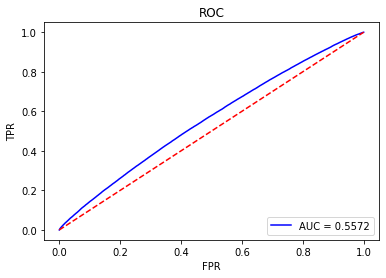

In [14]:
val_label = list()
for i in range(len(val_dataset)):
    val_label.append(val_dataset[i][1])
val_label = np.array(val_label)

print("Batch Size: {} | Learning Rate: {} - Min. Val. Loss: {} ".format(bs,lr,out_results['min_val_loss']))

accuracy = (np.array(val_pred) == val_label).sum().item() / len(val_dataset)
print("Val Accuracy: ", accuracy)
plot_roc(np.array(val_label), np.array(val_value))

## Test

In [10]:
image_height = {5: 32, 20: 64, 60: 96}  
image_width = {5: 15, 20: 60, 60: 180}

test_year = np.arange(2001,2010,1)
test_images = []
test_label_df = []

for year in test_year:
    test_images.append(np.memmap(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, image_height[20], image_width[20])))
    test_label_df.append(pd.read_feather(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
test_images = np.concatenate(test_images)
test_label_df = pd.concat(test_label_df)

y = test_label_df['Retx_20d_label'].to_numpy()
tmp = (np.isnan(y) | (y==2))
y = y[tmp==False]
test_images = test_images[tmp==False]
test_label_df = test_label_df[tmp==False]

print(test_images.shape)
print(test_label_df.shape)

(721820, 64, 60)
(721820, 35)


In [11]:
test_label = test_label_df["Retx_20d_label"]
test_label_value = test_label_df["Retx_20d"]
test_label = np.array(test_label)
test_label_value = np.array(test_label_value)

In [12]:
test_dataset = MyDataset(test_images, test_label)

100%|██████████| 2820/2820 [01:18<00:00, 36.02it/s]


Test Loss:  0.6913775515260426
Test Accuracy:  0.528972597046355
Correlation Spearman:  SpearmanrResult(correlation=0.07556613697091408, pvalue=0.0)
Correlation Pearson:  (0.05581029558584502, 0.0)


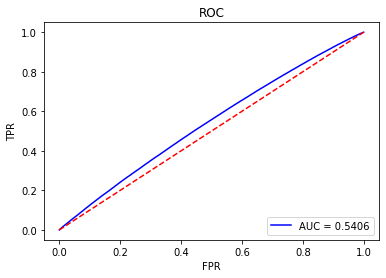

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
loss = nn.CrossEntropyLoss()

model = CNN().to(device)
model.load_state_dict(torch.load("CNN_no_xavier.pth.tar"))

testData = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True)
test_results, test_pred, test_value = evaluate(testData, model, loss, device)

print("Test Loss: ", test_results)
accuracy = (test_pred == test_dataset[:][1]).sum().item() / len(test_dataset)
print("Test Accuracy: ", accuracy)
print("Correlation Spearman: ", stats.spearmanr(list(test_value), list(test_label_df['Retx_20d'])))
print("Correlation Pearson: ", stats.pearsonr(list(test_value), list(test_label_df['Retx_20d'])))
plot_roc(np.array(test_label_df['Retx_20d_label']), np.array(test_value))

# Test2

In [10]:
image_height = {5: 32, 20: 64, 60: 96}  
image_width = {5: 15, 20: 60, 60: 180}

test_year = np.arange(2010,2020,1)
test_images = []
test_label_df = []

for year in test_year:
    test_images.append(np.memmap(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, image_height[20], image_width[20])))
    test_label_df.append(pd.read_feather(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
test_images = np.concatenate(test_images)
test_label_df = pd.concat(test_label_df)

y = test_label_df['Retx_20d_label'].to_numpy()
tmp = (np.isnan(y) | (y==2))
y = y[tmp==False]
test_images = test_images[tmp==False]
test_label_df = test_label_df[tmp==False]

print(test_images.shape)
print(test_label_df.shape)

(672933, 64, 60)
(672933, 35)


In [11]:
test_label = test_label_df["Retx_20d_label"]
test_label_value = test_label_df["Retx_20d"]
test_label = np.array(test_label)
test_label_value = np.array(test_label_value)

In [12]:
test_dataset = MyDataset(test_images, test_label)

100%|██████████| 2629/2629 [01:10<00:00, 37.18it/s]


Test Loss:  0.6943248472951945
Test Accuracy:  0.5172223683487064
Correlation Spearman:  SpearmanrResult(correlation=0.04322023651595884, pvalue=1.3695781710995267e-275)
Correlation Pearson:  (0.02298799085967179, 2.4285624173136652e-79)


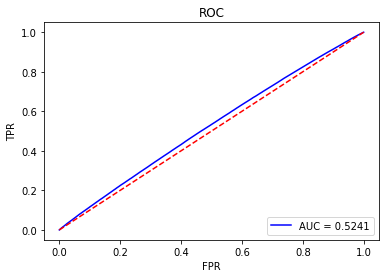

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
loss = nn.CrossEntropyLoss()

model = CNN().to(device)
model.load_state_dict(torch.load("CNN_no_xavier.pth.tar"))

testData = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True)
test_results, test_pred, test_value = evaluate(testData, model, loss, device)

print("Test Loss: ", test_results)
accuracy = (test_pred == test_dataset[:][1]).sum().item() / len(test_dataset)
print("Test Accuracy: ", accuracy)
print("Correlation Spearman: ", stats.spearmanr(list(test_value), list(test_label_df['Retx_20d'])))
print("Correlation Pearson: ", stats.pearsonr(list(test_value), list(test_label_df['Retx_20d'])))
plot_roc(np.array(test_label_df['Retx_20d_label']), np.array(test_value))

# Plot

In [15]:
CNN_out = torch.load('CNN_no_xavier_loss.pth.tar')

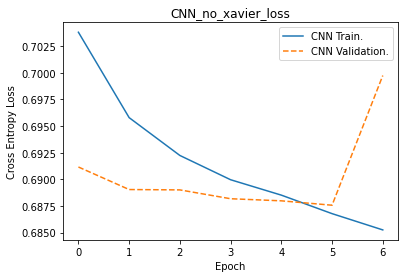

In [16]:
plt.title('CNN_no_xavier_loss')
plt.plot(CNN_out['train_losses'], label='CNN Train.')
plt.plot(CNN_out['val_losses'], label='CNN Validation.', linestyle='--')
_ = plt.ylabel('Cross Entropy Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend()
plt.savefig('CNN_no_xavier.png', bbox_inches='tight', dpi=200)